In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/mongodb_MapReduce/

/content/drive/MyDrive/mongodb_MapReduce


In [12]:
import torch as torch
import dlc_practical_prologue as prologue
import progressbar
from dlc_practical_prologue import *
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
train_input, train_target, test_input, test_target = load_data(cifar = True, one_hot_labels =True, normalize =True, flatten = True)

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [65]:
 train_input.shape

torch.Size([1000, 3072])

In [63]:
 test_input.shape

torch.Size([1000, 3072])

In [6]:
def loss(v,t):
  return torch.sum((t - v).pow(2))

In [7]:
def dloss(v, t):
  return  - 2 * (t - v)

In [8]:
def compute_error(pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones != target_ones).sum().item() / target.shape[0])

## Activation function

## 1. Uni-Polar Sigmoid Function

In [9]:
def sigmoid(x):
  s=1/(1+torch.exp(-x))
  return s

In [10]:
def dsigmoid(x):
  s=1/(1+torch.exp(-x))
  ds=s*(1-s)  
  return ds

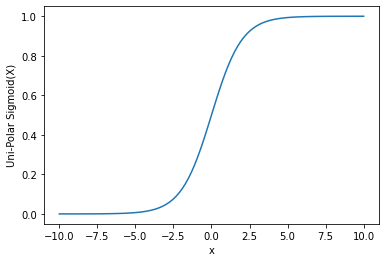

In [13]:
x = np.linspace(-10, 10, 100)
z1 = 1/(1 + np.exp(-x))
  
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Uni-Polar Sigmoid(X)")
  
plt.show()

In [90]:
class Neural_Network1:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.001, std=1e-9):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = sigmoid(x_1)
    x_2 = s_1 @ self.W2 + self.b2
    out =  sigmoid(x_2)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dsigmoid(x2)) 
    self.db2 = dloss(s2,t) * dsigmoid(x2)
    self.dW1 = x.T @ ((dloss(s2,t)*dsigmoid(x2)@ self.W2.T) * dsigmoid(x1))
    self.db1 = (dloss(s2,t)*dsigmoid(x2)@ self.W2.T) * dsigmoid(x1)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses1 = []
    train_losses1 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target  
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        test_loss = loss(model1.forward(test_input)[-1], test_target)
        test_losses1.append(test_loss)
        train_loss = loss(model1.forward(train_input)[-1], train_target)
        train_losses1.append(train_loss)
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {test_loss / test_input.shape[0]}')
    return (train_losses1, test_losses1)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [91]:
model1 = Neural_Network1(10,in_size=3072,out_size=10,lr=0.001)
train_losses1, test_losses1 = model1.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 1.9129249997138977 and Test loss: 1.4608227014541626
Epoch 100 Train Loss: 0.8894743906855583 and Test loss: 0.890497624874115
Epoch 200 Train Loss: 0.8146353899538517 and Test loss: 0.8434203863143921
Epoch 300 Train Loss: 0.7021716433465481 and Test loss: 0.8270214796066284
Epoch 400 Train Loss: 0.5713932524621487 and Test loss: 0.8391431570053101


In [92]:
pred1 = model1.forward(train_input)[-1]
model1.accuracy(pred1, train_target)

0.699

In [93]:
pred2 = model1.forward(test_input)[-1]
model1.accuracy(pred2, test_target)

0.296

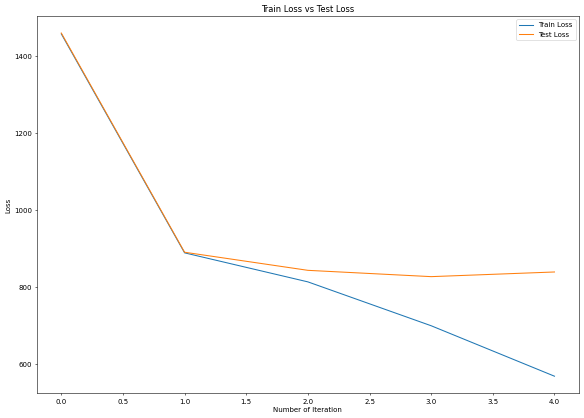

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 50)
plt.plot(train_losses1)
plt.plot(test_losses1)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 2. Bi-polar sigmoid function

In [125]:
def B_sigmoid(x):
  s=(1-torch.exp(-x))/(1+torch.exp(-x))
  return s

In [130]:
def dB_sigmoid(x):
  s=(2*torch.exp(-x))/((1+torch.exp(-x)).pow(2))
  ds= (s*(1-s))  
  return ds

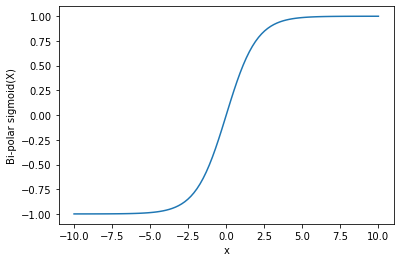

In [131]:
z2 = (1-np.exp(-x))/(1+np.exp(-x))
  
plt.plot(x, z2)
plt.xlabel("x")
plt.ylabel("Bi-polar sigmoid(X)")
  
plt.show()

In [137]:
class Neural_Network2:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.001, std=1e-9):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = B_sigmoid(x_1)
    x_2 = s_1 @ self.W2 + self.b2
    out =  B_sigmoid(x_2)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dB_sigmoid(x2)) 
    self.db2 = dloss(s2,t) * dB_sigmoid(x2)
    self.dW1 = x.T @ ((dloss(s2,t)*dB_sigmoid(x2)@ self.W2.T) * dB_sigmoid(x1))
    self.db1 = (dloss(s2,t)*dB_sigmoid(x2)@ self.W2.T) * dB_sigmoid(x1)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses2 = []
    train_losses2 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target  
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        test_loss = loss(model1.forward(test_input)[-1], test_target)
        test_losses1.append(test_loss)
        train_loss = loss(model1.forward(train_input)[-1], train_target)
        train_losses1.append(train_loss)
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {test_loss / test_input.shape[0]}')
    return (train_losses1, test_losses1)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [138]:
model2 = Neural_Network2(10,in_size=3072,out_size=10,lr=0.001)
train_losses2, test_losses2 = model2.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.9788265027999878 and Test loss: 0.8597517013549805
Epoch 100 Train Loss: 0.7106799112856388 and Test loss: 0.8597517013549805
Epoch 200 Train Loss: 0.4800713755860925 and Test loss: 0.8597517013549805
Epoch 300 Train Loss: 0.32029196128621695 and Test loss: 0.8597517013549805
Epoch 400 Train Loss: 0.2323376976214349 and Test loss: 0.8597517013549805


In [139]:
pred2 = model2.forward(train_input)[-1]
model2.accuracy(pred2, train_target)

0.994

In [140]:
pred2 = model2.forward(test_input)[-1]
model2.accuracy(pred2, test_target)

0.189

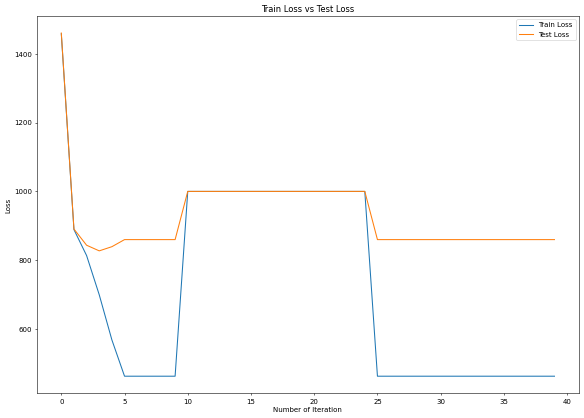

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 50)
plt.plot(train_losses2)
plt.plot(test_losses2)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 3. Hyperbolic Tangent Function

In [142]:
def sigma(x):
  return torch.tanh(x)

In [143]:
def dsigma(x):
  return 1 - torch.tanh(x)**2

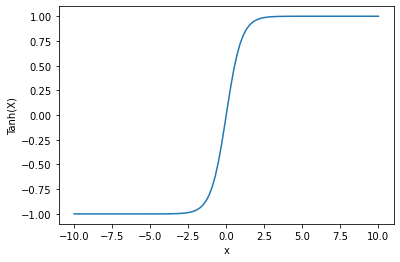

In [144]:
z3 = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

plt.plot(x, z3)
plt.xlabel("x")
plt.ylabel("Tanh(X)")
  
plt.show()

In [150]:
class Neural_Network3:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-9):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = sigma(x_1)
    x_2 = s_1 @ self.W2 + self.b2
    out =  sigma(x_2)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dsigma(x2)) 
    self.db2 = dloss(s2,t) * dsigma(x2)
    self.dW1 = x.T @ ((dloss(s2,t)*dsigma(x2)@ self.W2.T) * dsigma(x1))
    self.db1 = (dloss(s2,t)*dsigma(x2)@ self.W2.T) * dsigma(x1)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses3 = []
    train_losses3 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target 
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        test_loss = loss(model3.forward(test_input)[-1], test_target)
        test_losses1.append(test_loss)
        train_loss = loss(model3.forward(train_input)[-1], train_target)
        train_losses1.append(train_loss)
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {test_loss / test_input.shape[0]}')
    return (train_losses1, test_losses1)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [151]:
model3 = Neural_Network3(10,in_size=3072,out_size=10,lr=0.01)
train_losses3, test_losses3 = model3.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.9155088273882865 and Test loss: 0.9031590223312378
Epoch 100 Train Loss: 0.5389964988082647 and Test loss: 1.0937432050704956
Epoch 200 Train Loss: 0.47013020717725157 and Test loss: 1.1661181449890137
Epoch 300 Train Loss: 0.4427118841744959 and Test loss: 1.1810400485992432
Epoch 400 Train Loss: 0.4207528204731643 and Test loss: 1.2381848096847534


In [152]:
pred3 = model3.forward(train_input)[-1]
model3.accuracy(pred3, train_target)

0.874

In [153]:
pred3 = model3.forward(test_input)[-1]
model3.accuracy(pred3, test_target)

0.206

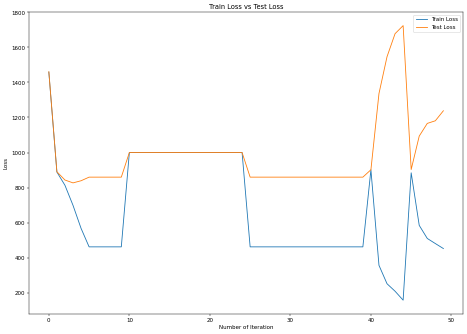

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses3)
plt.plot(test_losses3)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 4. Radial Basis Function

In [ ]:
def Radial(x, a):
  e = 0.6
  torch.exp(-e*x*x)
  np.abs(x - c)
  return torch.where(x>0, torch.tanh(x), a*torch.tanh(x))

In [ ]:
def dtanh(x, a):
  t = torch.tanh(x)
  return torch.where(x>0, 1-t**2, a*(1-t**2))

In [45]:
e = 0.6 # epsilon

def gaussian(x):
    return np.exp(-e*x*x)

In [46]:
#Euclidean norm in R
def norm(x, c):
    return np.abs(x - c)

No handles with labels found to put in legend.


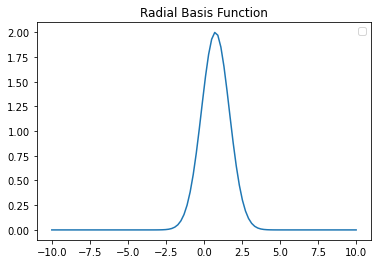

In [47]:
c = 0.75
w = 2
def psi(x):
    return f1*gaussian(norm(x, x1))

plt.plot(x, psi(x))
plt.plot(c, w)

plt.title('Radial Basis Function')
plt.legend(loc='upper right')
plt.show()

In [ ]:
class Neural_Network4:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = tanh(x_1, 0.25)
    x_2 = s_1 @ self.W2 + self.b2
    out =  tanh(x_2, 0.25)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dtanh(x2, 0.25)) 
    self.db2 = dloss(s2,t) * dtanh(x2, 0.25)
    self.dW1 = x.T @ ((dloss(s2,t)*dtanh(x2, 0.25)@ self.W2.T) * dtanh(x1, 0.25))
    self.db1 = (dloss(s2,t)*dtanh(x2, 0.25)@ self.W2.T) * dtanh(x1, 0.25)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses4 = []
    train_losses4 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model4.forward(test_input)[-1], test_target*0.9)
        train_losses4.append(train_loss)
        test_losses4.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses4, test_losses4)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [ ]:
model4 = Neural_Network4(50,in_size=3072,out_size=10,lr=0.25)
train_losses4, test_losses4 = model4.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.7252363239005208 and Test loss: 0.705921471118927
Epoch 100 Train Loss: 0.08047511616535485 and Test loss: 1.0342426300048828
Epoch 200 Train Loss: 0.0585998527482152 and Test loss: 1.0978611707687378
Epoch 300 Train Loss: 0.05228255919646472 and Test loss: 1.1228859424591064
Epoch 400 Train Loss: 0.04690475866105408 and Test loss: 1.1525079011917114


In [ ]:
pred4 = model4.forward(train_input)[-1]
model4.accuracy(pred4, train_target)

1.0

In [ ]:
pred4 = model4.forward(test_input)[-1]
model4.accuracy(pred4, test_target)

0.227

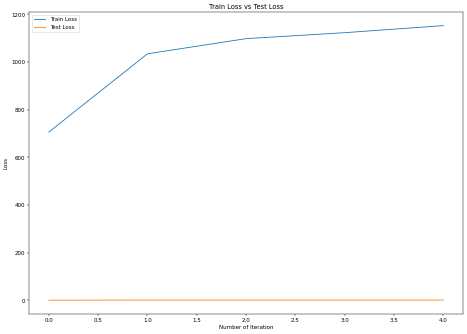

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses4)
plt.plot(test_losses4)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 5. Conic Section Function

In [ ]:
def ReLU(x):
  return x * torch.where(x>0) 

In [ ]:
def dReLU(x):
  return 1 * torch.where(x>0) 

In [ ]:
z5 = 1/(1 + np.exp(-x))
  
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
  
plt.show()

In [ ]:
class Neural_Network5:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = tanh(x_1, 0.25)
    x_2 = s_1 @ self.W2 + self.b2
    out =  tanh(x_2, 0.25)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dtanh(x2, 0.25)) 
    self.db2 = dloss(s2,t) * tanh(x2, 0.25)
    self.dW1 = x.T @ ((dloss(s2,t)*tanh(x2, 0.25)@ self.W2.T) * tanh(x1, 0.25))
    self.db1 = (dloss(s2,t)*tanh(x2, 0.25)@ self.W2.T) * tanh(x1, 0.25)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses5 = []
    train_losses5 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model5.forward(test_input)[-1], test_target*0.9)
        train_losses5.append(train_loss)
        test_losses5.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses5, test_losses5)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [ ]:
model5 = Neural_Network5(50,in_size=3072,out_size=10,lr=0.25)
train_losses5, test_losses5 = model5.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.80999906873703 and Test loss: 0.8099977970123291
Epoch 100 Train Loss: 1.189511601984501 and Test loss: 1.1921335458755493
Epoch 200 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 300 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 400 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673


In [ ]:
pred5 = model5.forward(train_input)[-1]
model5.accuracy(pred5, train_target)

0.102

In [ ]:
pred5 = model5.forward(test_input)[-1]
model5.accuracy(pred5, test_target)

0.103

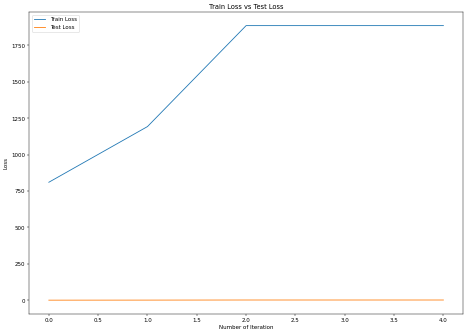

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses5)
plt.plot(test_losses5)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()